In [1]:
!pip install numerapi halo

import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import gc
import json
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

from numerapi import NumerAPI

import sys
sys.path.insert(1, "/kaggle/input/utilspy/")

from utils import (
    save_model,
#     load_model,
    neutralize,
    validation_metrics,
    ERA_COL,
    DATA_TYPE_COL,
    TARGET_COL,
    EXAMPLE_PREDS_COL,
)

# # download all the things
# PUBLIC_ID = "AFL3X7DE3VPROC25KPSENXRB5C5D23RU"
# SECRET_KEY = "I5ACBG5FY4BIEB6SY3JNT2YH4YFQPWSWOJ5MVX3XKEQZZ2Y6UCBXLVC4VIQK56XW"

# # Initialize API with API Keys
napi = NumerAPI()

# napi = NumerAPI(public_id=PUBLIC_ID, 
#                          secret_key=SECRET_KEY, 
#                          verbosity="info")

# current_round = napi.get_current_round()
# print(f"The current round is {current_round}")

# # # Tournament data changes every week so we specify the round in their name. Training
# # # and validation data only change periodically, so no need to download them every time.
# # print("Downloading dataset files...")
dataset_name = "v4.1"
feature_set_name = "all"

Path(f"./{dataset_name}").mkdir(parents=False, exist_ok=True)

# we'll use the int8 in this example in order to save RAM.
# if you remove the int8 suffix for each of these files, you'll get features between 0 and 1 as floats.
# int_8 files are much smaller...
# but are harder to work with because some packages don't like ints and the way NAs are encoded.

# napi.download_dataset(f"{dataset_name}/train.parquet")
# # napi.download_dataset(f"{dataset_name}/validation.parquet")
# # napi.download_dataset(f"{dataset_name}/live.parquet", f"{dataset_name}/live_{current_round}.parquet")

napi.download_dataset(f"{dataset_name}/train_int8.parquet")
# napi.download_dataset(f"{dataset_name}/validation_int8.parquet")
# napi.download_dataset(f"{dataset_name}/live_int8.parquet", f"{dataset_name}/live_int8_{current_round}.parquet")

# napi.download_dataset(f"{dataset_name}/validation_example_preds.parquet")
napi.download_dataset(f"{dataset_name}/features.json")


print("Reading minimal training data")
# read the feature metadata and get a feature set (or all the features)

with open(f"{dataset_name}/features.json", "r") as f:
    feature_metadata = json.load(f)

features = list(feature_metadata["feature_stats"].keys()) # get all the features
# features = gc  # get the small feature set
# features = feature_metadata["feature_sets"][feature_set_name]  # get the medium feature set
target_cols = feature_metadata["targets"]
# read in just those features along with era and target columns
read_columns = features + target_cols + [ERA_COL, DATA_TYPE_COL]

# note: sometimes when trying to read the downloaded data you get an error about invalid magic parquet bytes...
# if so, delete the file and rerun the napi.download_dataset to fix the corrupted file
training_data = pd.read_parquet(
    f"{dataset_name}/train_int8.parquet", columns=read_columns
)
# validation_data = pd.read_parquet(
#     f"{path+dataset_name}/validation_int8.parquet", columns=read_columns
# )
# live_data = pd.read_parquet(f"{dataset_name}/live_int8_{current_round}.parquet", columns=read_columns)

print("Training data:")
print(f"There are {len(features)} features")
print(f"There are {len(training_data[ERA_COL].unique())} eras numbered from {training_data[ERA_COL].unique()[0]} to {training_data[ERA_COL].unique()[-1]}")
print(f"There are {len(target_cols)-1} targets named {target_cols[1:]}")
print("----------------------------------------------------------------------")
# print("Validation data:")
# print(f"There are {len(validation_data[ERA_COL].unique())} eras numbered from {validation_data[ERA_COL].unique()[0]} to {validation_data[ERA_COL].unique()[-1]}")
# print("----------------------------------------------------------------------")
# print("Live data:")
# print(f"There are {len(live_data[ERA_COL].unique())} eras numbered from {live_data[ERA_COL].unique()[0]} to {live_data[ERA_COL].unique()[-1]}")

  Preparing metadata (setup.py) ... done
  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11261 sha256=fc8e2dd720da0211490417036a80c26a8a92d3180e42d53c6e2af662722c0150
  Stored in directory: /root/.cache/pip/wheels/41/c9/fc/65b2a2aec7a71b08ba8cce6f77e6311290cf646f42d41d7c28
Successfully built halo


v4.1/train_int8.parquet: 1.45GB [01:13, 19.9MB/s]                             
v4.1/features.json: 703kB [00:00, 1.05MB/s]                            


Reading minimal training data
Training data:
There are 1586 features
There are 574 eras numbered from 0001 to 0574
There are 36 targets named ['target_nomi_v4_20', 'target_nomi_v4_60', 'target_tyler_v4_20', 'target_tyler_v4_60', 'target_victor_v4_20', 'target_victor_v4_60', 'target_ralph_v4_20', 'target_ralph_v4_60', 'target_waldo_v4_20', 'target_waldo_v4_60', 'target_jerome_v4_20', 'target_jerome_v4_60', 'target_janet_v4_20', 'target_janet_v4_60', 'target_ben_v4_20', 'target_ben_v4_60', 'target_alan_v4_20', 'target_alan_v4_60', 'target_paul_v4_20', 'target_paul_v4_60', 'target_george_v4_20', 'target_george_v4_60', 'target_william_v4_20', 'target_william_v4_60', 'target_arthur_v4_20', 'target_arthur_v4_60', 'target_thomas_v4_20', 'target_thomas_v4_60', 'target_cyrus_v4_20', 'target_cyrus_v4_60', 'target_caroline_v4_20', 'target_caroline_v4_60', 'target_sam_v4_20', 'target_sam_v4_60', 'target_xerxes_v4_20', 'target_xerxes_v4_60']
---------------------------------------------------------

In [2]:
feature_metadata

{'feature_stats': {'feature_honoured_observational_balaamite': {'legacy_uniqueness': nan,
   'spearman_corr_w_target_nomi_20_mean': -0.0008683258726933546,
   'spearman_corr_w_target_nomi_20_sharpe': -0.08497302517948851,
   'spearman_corr_w_target_nomi_20_reversals': 7.04618724549861e-05,
   'spearman_corr_w_target_nomi_20_autocorr': 0.032672629137608836,
   'spearman_corr_w_target_nomi_20_arl': 3.92018779342723},
  'feature_polaroid_vadose_quinze': {'legacy_uniqueness': nan,
   'spearman_corr_w_target_nomi_20_mean': 0.00016230089241112643,
   'spearman_corr_w_target_nomi_20_sharpe': 0.016115632380543407,
   'spearman_corr_w_target_nomi_20_reversals': 8.111279552770912e-05,
   'spearman_corr_w_target_nomi_20_autocorr': -0.012822758725293527,
   'spearman_corr_w_target_nomi_20_arl': 3.5531914893617023},
  'feature_untidy_withdrawn_bargeman': {'legacy_uniqueness': nan,
   'spearman_corr_w_target_nomi_20_mean': -0.0007706626550766353,
   'spearman_corr_w_target_nomi_20_sharpe': -0.087548

In [4]:
training_data.head()

,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,feature_floriated_amish_sprite,feature_iconoclastic_parietal_agonist,...,target_cyrus_v4_20,target_cyrus_v4_60,target_caroline_v4_20,target_caroline_v4_60,target_sam_v4_20,target_sam_v4_60,target_xerxes_v4_20,target_xerxes_v4_60,era,data_type
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,4,2,4,4,0,0,4,4,3,0,...,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0001,train
n003bee128c2fcfc,2,4,1,3,0,3,2,3,2,2,...,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0001,train
n0048ac83aff7194,2,1,3,0,3,0,3,3,4,2,...,0.25,0.25,0.50,0.25,0.50,0.25,0.25,0.25,0001,train
n00691bec80d3e02,4,2,2,3,0,4,1,4,1,3,...,0.75,0.50,0.75,0.50,0.75,0.50,0.75,0.50,0001,train
n00b8720a2fdc4f2,4,3,4,4,0,0,4,2,3,0,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0001,train


In [3]:
training_data.era

id
n003bba8a98662e4    0001
n003bee128c2fcfc    0001
n0048ac83aff7194    0001
n00691bec80d3e02    0001
n00b8720a2fdc4f2    0001
                    ... 
nffcc1dbdf2212e6    0574
nffd71b7f6a128df    0574
nffde3b371d67394    0574
nfff1a1111b35e84    0574
nfff2bd38e397265    0574
Name: era, Length: 2420521, dtype: object

In [7]:
X.head()

,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,feature_floriated_amish_sprite,feature_iconoclastic_parietal_agonist,...,feature_aged_phylacterical_pusey,feature_revisional_ablutionary_depression,feature_yokelish_metapsychological_lunt,feature_circumlunar_chaliced_seam,feature_squallier_prototypal_dammar,feature_cognate_elating_ravine,feature_ethiopian_carminative_retentivity,feature_alabamian_outlying_monitoring,feature_byzantine_festinate_mannose,feature_sleetier_sea_potamogeton
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,4,2,4,4,0,0,4,4,3,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
n003bee128c2fcfc,2,4,1,3,0,3,2,3,2,2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
n0048ac83aff7194,2,1,3,0,3,0,3,3,4,2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
n00691bec80d3e02,4,2,2,3,0,4,1,4,1,3,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
n00b8720a2fdc4f2,4,3,4,4,0,0,4,2,3,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [37]:
X = training_data[training_data.era == "0001"][features]
X = X.dropna(axis=1).astype("int8")
y = training_data[training_data.era == "0001"]["target_cyrus_v4_20"].astype("int8")
print(X.shape, y.shape)

discrete_features = X.dtypes == "int8"
print(discrete_features)

(2072, 1206) (2072,)
feature_honoured_observational_balaamite        True
feature_polaroid_vadose_quinze                  True
feature_untidy_withdrawn_bargeman               True
feature_genuine_kyphotic_trehala                True
feature_unenthralled_sportful_schoolhouse       True
                                                ... 
feature_diarrhoeic_relieved_scutter             True
feature_profaned_obsequent_urology              True
feature_unrecognisable_ultrabasic_corporeity    True
feature_reposeful_apatetic_trudeau              True
feature_seismograph_molybdic_requisition        True
Length: 1206, dtype: bool


In [38]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, True)
mi_scores[:30]  # show a few features with their MI scores

feature_directoire_propositional_clydebank      0.009121
feature_acclimatisable_unfeigned_maghreb        0.009118
feature_dada_draughtiest_cinchonisation         0.009089
feature_synodal_thornier_zila                   0.009074
feature_relinquished_incognizable_batholith     0.008780
feature_jammed_stearic_gaper                    0.008548
feature_reposeful_apatetic_trudeau              0.008431
feature_smaller_colored_immurement              0.008088
feature_accommodable_crinite_cleft              0.007990
feature_wally_unrotted_eccrinology              0.007849
feature_gathered_owlish_judgment                0.007829
feature_unadaptable_floored_styptic             0.007804
feature_eucharistic_widowed_misfeasance         0.007665
feature_cosy_microtonal_cedar                   0.007660
feature_neutered_postpositive_writ              0.007604
feature_smouldering_underground_wingspan        0.007495
feature_clipped_kurdish_grainer                 0.007192
feature_idled_unwieldy_improvem

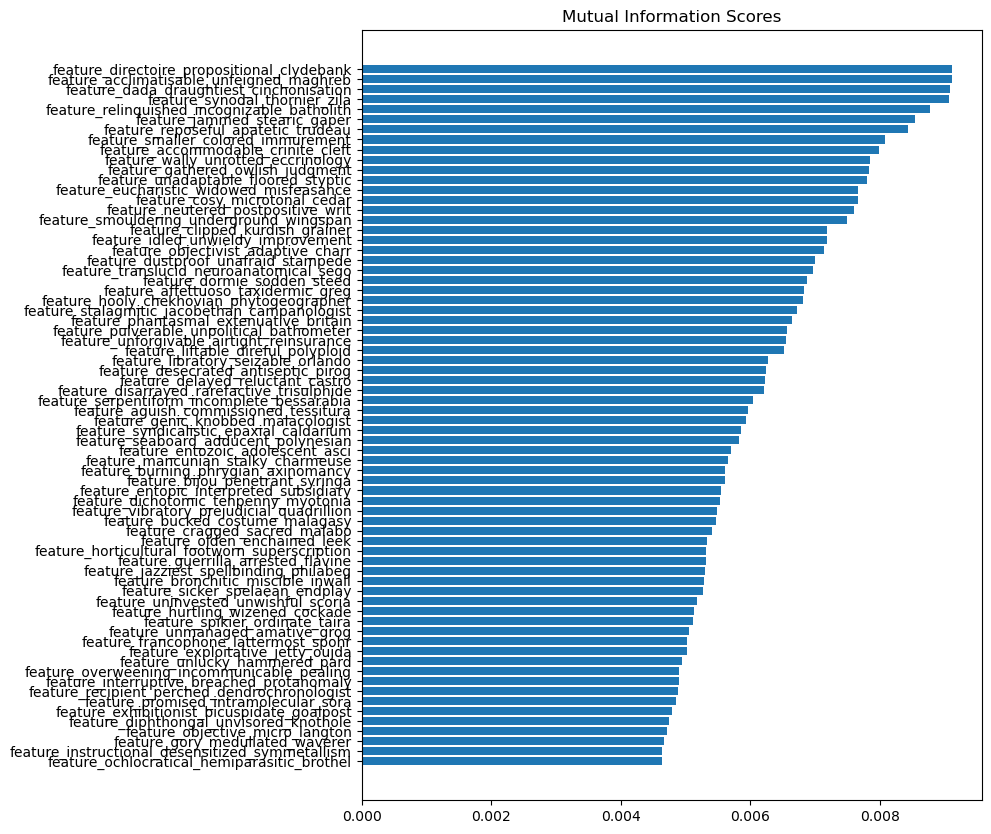

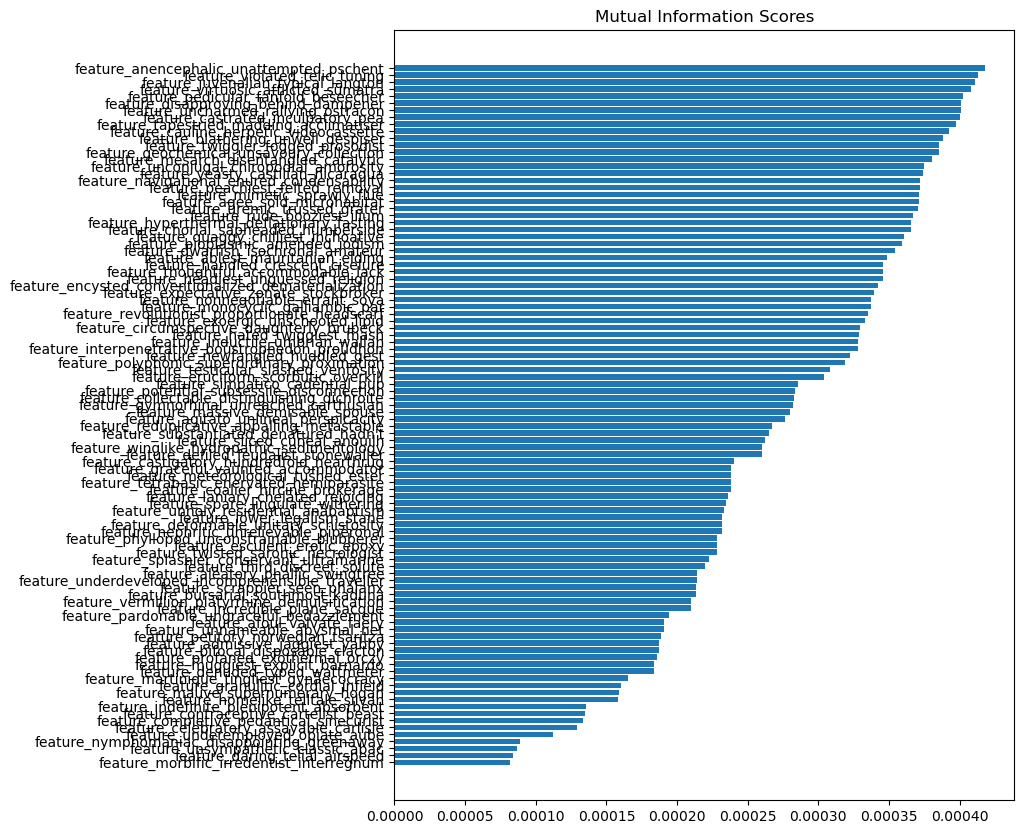

In [43]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 10))
plot_mi_scores(mi_scores[:70])

plt.figure(dpi=100, figsize=(8, 10))
plot_mi_scores(mi_scores[-100:])

In [5]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

(2420521, 10) (2420521,)
feature_honoured_observational_balaamite     True
feature_polaroid_vadose_quinze               True
feature_untidy_withdrawn_bargeman            True
feature_genuine_kyphotic_trehala             True
feature_unenthralled_sportful_schoolhouse    True
feature_divulsive_explanatory_ideologue      True
feature_ichthyotic_roofed_yeshiva            True
feature_waggly_outlandish_carbonisation      True
feature_floriated_amish_sprite               True
feature_iconoclastic_parietal_agonist        True
dtype: bool
feature_iconoclastic_parietal_agonist        0.001669
feature_genuine_kyphotic_trehala             0.001463
feature_polaroid_vadose_quinze               0.001336
feature_divulsive_explanatory_ideologue      0.001080
feature_unenthralled_sportful_schoolhouse    0.000918
feature_waggly_outlandish_carbonisation      0.000737
feature_untidy_withdrawn_bargeman            0.000569
feature_floriated_amish_sprite               0.000409
feature_ichthyotic_roofed_yeshi

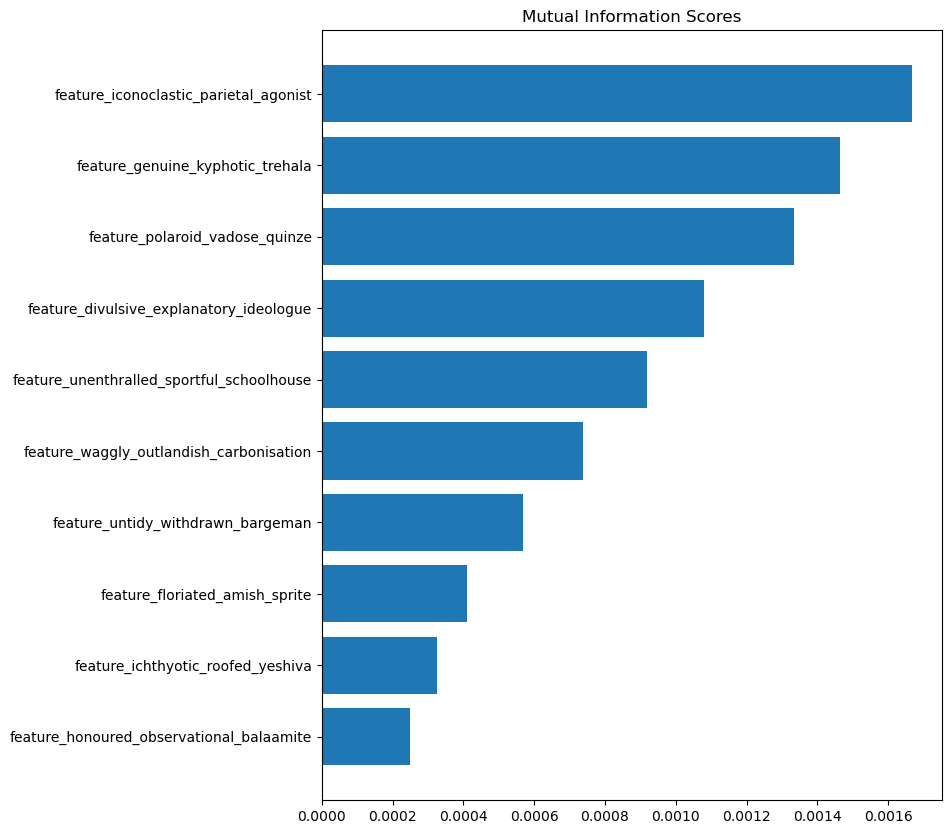

In [9]:
X = training_data[features[:10]]
X = X.fillna(X.median(axis=1)).astype("int8")
y = training_data["target_cyrus_v4_20"].astype("int8")
print(X.shape, y.shape)

discrete_features = X.dtypes == "int8"
print(discrete_features)

mi_scores = make_mi_scores(X, y, True)
print(mi_scores[:30])  # show a few features with their MI scores

plt.figure(dpi=100, figsize=(8, 10))
plot_mi_scores(mi_scores[:70])

In [11]:
import pandas as pd
from scipy.stats import spearmanr

# Separate the input features (X) and the output variable (y)
# X = training_data[features[:10]]
# X = X.fillna(X.median(axis=1)).astype("int8")
# y = training_data["target_cyrus_v4_20"].astype("int8")

X = training_data[features]
y = training_data["target_cyrus_v4_20"]
print(X.shape, y.shape)


# Calculate the Spearman rank correlation coefficients
correlations = []
p_values = []
for feature in X.columns:
    correlation, p_value = spearmanr(X[feature], y)
    correlations.append(abs(correlation))
    p_values.append(p_value)

# Create a DataFrame to store the correlation coefficients and p-values
correlation_df = pd.DataFrame({'Feature': X.columns, 'Correlation': correlations, 'p-value': p_values})

# Sort the DataFrame by the absolute values of the correlation coefficients in descending order
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Select the top features based on your desired number
top_features = correlation_df.head(10)  # Replace '5' with the desired number of top features

# Print the top features and their correlation coefficients
print(top_features)


(2420521, 1586) (2420521,)


KeyboardInterrupt: 

In [ ]:
# # The features are no longer explicit feature groups, but you can see some pretty obvious patterns if you
# # visualize the feature correlation matrix. Feel free to construct your own groupings!
# plt.figure(figsize = (6,6))
# plt.imshow(training_data[training_data.era=='0001'][features].corr())

In [ ]:
# # The earlier eras are smaller, but generally each era is 4000-5000 rows
# training_data.groupby(ERA_COL).size().plot()

# Feature Importance

In [ ]:
# ADDITION by me
training_indexes = []
validation_indexes = []
for i in range(4):
    every_4th_era = training_data[ERA_COL].unique()[i::4]
    training_indexes.append(training_data[training_data[ERA_COL].isin(every_4th_era)].index)
#     every_4th_era = validation_data[ERA_COL].unique()[i::4]
#     validation_indexes.append(validation_data[validation_data[ERA_COL].isin(every_4th_era)].index)
    print(f'Getting training and validation indices: {i+1}/4')
    
# get all the data to possibly use for training
# all_data = pd.concat([training_data, validation_data])

# delete training and validation data to save space
# del training_data
# del validation_data
gc.collect()  # clear up memory

# Int8 datatype has pd.NA which don't play nice with models.  We simply fill NA with median values here
print("Cleaning up NAs")
medians = training_data[features].median(skipna=True).astype("int8")
# all_data[features] = all_data[features].fillna(medians)
# all_data[features] = all_data[features].astype("int8")  # make sure change to float32 if using the non int8 data!
# live_data[features] = live_data[features].fillna(medians)  # since live data is only one era, we need to use the median for all eras
# live_data[features] = live_data[features].astype("int8")  # make sure change to float32 if using the non int8 data!
training_data[features] = training_data[features].fillna(medians)  # since live data is only one era, we need to use the median for all eras
training_data[features] = training_data[features].astype("int8") 

# Alternatively could convert nan columns to be floats and replace pd.NA with np.nan
print("Cleaned up NAs")

# pd.to_pickle(pd.Series(training_indexes), f"training_indices.pkl")
# pd.to_pickle(pd.Series(validation_indexes), f"validation_indices.pkl")
# pd.to_pickle(all_data, f"all_data.pkl")
# pd.to_pickle(live_data, f"live_data.pkl")

In [ ]:
def load_model(path):
    path = Path(f"{path}.pkl")
    print(path)
    if path.is_file():
        model = pd.read_pickle(f"{path}")
    else:
        model = False
    return model

model_folders = ["numerai-train-nomi-v4-20", "numerai-train-jerome-v4-60", "numerai-train-ralph-v4-20", "numerai-train-tyler-v4-20", "numerai-train-victor-v4-20", "numerai-train-waldo-v4-20"]

In [ ]:
# # Very small fast params
# params_name = "vsm_lgbm"
# params = {"n_estimators": 200,
#           "learning_rate": 0.1,
#           "max_depth": 4,
#           "num_leaves": 2 ** 4,
#           "colsample_bytree": 0.1}

# # small fast params
# params_name = "sm_lgbm"
# params = {"n_estimators": 2000,
#           "learning_rate": 0.01,
#           "max_depth": 5,
#           "num_leaves": 2 ** 5,
#           "colsample_bytree": 0.1}

# recommended params
params_name = "lg_lgbm"
params = {
    "n_estimators": 20000,
    "learning_rate": 0.001,
    "max_depth": 6,
    "num_leaves": 2**6,
    "colsample_bytree": 0.1,
}

# loop through all of our favorite targets and build models on each of them - one over training data, one over all available data
# for the train_data models, we'll then predict on validation data
# for the all_data models, we'll predict on live
targets = [
    "target_nomi_v4_20",
    "target_jerome_v4_60",
    "target_ralph_v4_20",
    "target_tyler_v4_20",
    "target_victor_v4_20",
    "target_waldo_v4_20",
]

fi_results = pd.DataFrame({'Features': features})
imp_cols = []

for target, model_folder in zip(tqdm(targets), model_folders):
    for i, training_index in enumerate(tqdm(training_indexes)):
        prediction_col = f"{params_name}_{dataset_name}_{feature_set_name}_erasplit{i}_{target}"
        train_data_model_name = f"train_data_{prediction_col}.pkl"
#         print(f"Checking for existing model '{train_data_model_name}'")
#         train_model = pd.read_pickle(models_path+train_data_model_name)
        train_model = load_model(f"/kaggle/input/{model_folder}/models/{train_data_model_name}")

        if not train_model:
            print(f"Model not found, creating new one")
            train_model = LGBMRegressor(**params)
            # train on all of train and save the model so we don't have to train next time
            target_train_index = (training_data.loc[training_index, target].dropna().index)  # make sure we only train on rows which have this target
            train_model.fit(training_data.loc[target_train_index, features], training_data.loc[target_train_index, target])
            print(f"Saving new model: {train_data_model_name}")
            save_model(train_model, train_data_model_name)
            
        print(f"Model found")

        feature_importances = (train_model.feature_importances_ / sum(train_model.feature_importances_)) * 100
        fi_results[f'Importances {target} {i}'] = feature_importances
        imp_cols.append(f'Importances {target} {i}')
        
        







# prediction_cols = []
# for target in tqdm(targets):
#     for i, (training_index,validation_index) in enumerate(zip(training_indexes, validation_indexes)):
#         prediction_col = f"{params_name}_{dataset_name}_{feature_set_name}_erasplit{i}_{target}"
#         train_data_model_name = f"train_data_{prediction_col}.pkl"
#         print(f"Checking for existing model '{train_data_model_name}'")
#         train_model = pd.read_pickle(models_path+train_data_model_name)
#         print(f"Found model: {train_model}")
#         if not train_model:
#             print(f"Model not found, creating new one")
#             train_model = LGBMRegressor(**params)
#             # train on all of train and save the model so we don't have to train next time
#             target_train_index = (all_data.loc[training_index, target].dropna().index)  # make sure we only train on rows which have this target
#             train_model.fit(
#                 all_data.loc[target_train_index, features],
#                 all_data.loc[target_train_index, target],
#             )  # in case some of the targets are missing data
#             print(f"Saving new model: {train_data_model_name}")
#             save_model(train_model, train_data_model_name)

#         # predict on validation data
#         print(f"Predicting on validation data")
#         all_data.loc[validation_index, prediction_col] = train_model.predict(
#             all_data.loc[validation_index, features]
#         )
#         gc.collect()

#         # do the same thing for all data (for predicting on live)
#         all_index = training_index.union(validation_index)
#         all_data_model_name = f"all_data_{prediction_col}.pkl"
#         print(f"Checking for existing model '{all_data_model_name}'")
#         all_data_model = pd.read_pickle(models_path+all_data_model_name)
#         print(f"Found model: {all_data_model}")
#         if not all_data_model:
#             print(f"Model not found, creating new one")
#             all_data_model = LGBMRegressor(**params)
#             all_data_target_index = (
#                 all_data.loc[all_index, target].dropna().index
#             )  # make sure we only train on rows which have this target
#             # train on all of train and save the model so we don't have to train next time
#             all_data_model.fit(
#                 all_data.loc[all_data_target_index, features],
#                 all_data.loc[all_data_target_index, target],
#             )
#             print(f"Saving new model: {all_data_model_name}")
#             save_model(all_data_model, all_data_model_name)

#         # predict on live data
#         print(f"Predicting on live data")
#         live_data[prediction_col] = all_data_model.predict(
#             live_data[features].fillna(np.nan)
#         )  # filling live data with nans makes us ignore those features if necessary
#         gc.collect()

#         prediction_cols.append(prediction_col)

In [ ]:
fi_results['avg importance'] = fi_results[imp_cols].mean(axis=1)
fi_results['std importance'] = fi_results[imp_cols].std(axis=1)

fi_results.sort_values(by=['avg importance', 'std importance'], inplace=True)

ax = plt.barh(fi_results['Features'], fi_results['avg importance'])
plt.xlabel('Importance percentage averages')
plt.yticks([]) 
plt.show()

ax = plt.barh(fi_results['Features'], fi_results['std importance'])
plt.xlabel('Importance stds')
plt.yticks([]) 
plt.show()

# pd.to_pickle(fi_results, f"fi_results.pkl")

In [ ]:
fi_results['avg importance']

In [ ]:
features_high_avg = fi_results[fi_results['avg importance'] > 0.1]['Features'].values.tolist() # 46 features
features_med_avg = fi_results[fi_results['avg importance'] > 0.075]['Features'].values.tolist() # 277 features
features_low_avg = fi_results[fi_results['avg importance'] > 0.05]['Features'].values.tolist() # 1314 features
features_low_avg_high_std = fi_results[(fi_results['avg importance'] > 0.05) & (fi_results['std importance'] < 0.01)]['Features'].values.tolist() # 714 features
features_low_avg_med_std = fi_results[(fi_results['avg importance'] > 0.05) & (fi_results['std importance'] < 0.0075)]['Features'].values.tolist() # 410 features
features_low_avg_low_std = fi_results[(fi_results['avg importance'] > 0.05) & (fi_results['std importance'] < 0.005)]['Features'].values.tolist() # 112 features

my_features = [features_high_avg, features_med_avg, features_low_avg, features_low_avg_high_std, features_low_avg_med_std, features_low_avg_low_std]
my_features_names = ['features_high_avg', 'features_med_avg', 'features_low_avg', 'features_low_avg_high_std', 'features_low_avg_med_std', 'features_low_avg_low_std']

my_feature_dict = {k: v for k, v in zip(my_features_names, my_features)}

# Save dictionary to JSON file
with open('my_features.json', 'w') as f:
    json.dump(my_feature_dict, f)

In [ ]:
features_sm = feature_metadata["feature_sets"]["small"] # get the small feature set
features_m = feature_metadata["feature_sets"]['medium']  # get the medium feature set
features_v2 = feature_metadata["feature_sets"]['v2_equivalent_features']  # get the v2 equivalent feature set
features_v3 = feature_metadata["feature_sets"]['v3_equivalent_features']  # get the v3 equivalent feature set
features_fncv3 = feature_metadata["feature_sets"]['fncv3_features']  # get the fncv3 feature set

numerai_features = [features_sm, features_m, features_v2, features_v3, features_fncv3]
numerai_features_names = ['features_sm', 'features_m', 'features_v2', 'features_v3', 'features_fncv3']

In [ ]:
from sklearn.metrics import confusion_matrix

cm = np.empty((len(my_features), len(numerai_features)))
for i,list1 in enumerate(my_features):
    for j,list2 in enumerate(numerai_features):
        cm[i,j] = sum([1 for value in list1 if value in list2])/len(list2)

print(cm)

# Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(cm)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set axis labels and title
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(numerai_features_names, rotation=90)
ax.set_yticklabels(my_features_names)

ax.set_title('Heatmap Example')

# Loop over data dimensions and create annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, round(cm[i, j],2),
                       ha="center", va="center", color="w")

# Show plot
plt.show()